# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** **J**

**Names:**

* *Rafael Bischof*
* *Jeniffer Lima Graf*
* *Alexander Sanchez*

---

#### Instructions

*This is a template for part 1 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

In [29]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import csv

---

## 2.1 Exploration of real networks

#### Exercise 2.1
Your first task is to explore network1 and analyze its properties.<br>
1.  Load the graph in your favorite data structure.<br>
2.  How many nodes and edges does the graph contain?

In [30]:
with open('../data/network1.csv') as file:
    data=[tuple(line) for line in csv.reader(filter(lambda row: row[0]!='#', file))]

G = nx.Graph(data)
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())
degrees = np.fromiter(dict(G.degree()).values(), dtype=int)
print('Average degree:', np.mean(degrees))
print('Highest degree:', sorted(degrees)[-1])

Number of nodes: 13033
Number of edges: 18584
Average degree: 2.8518376429064682
Highest degree: 1482


#### Exercise 2.2:  Node degree distribution

In [ ]:
from scipy.stats import pareto

def node_degree_distribution(G, bins):
    degrees = np.fromiter(dict(G.degree()).values(), dtype=int)
    values = np.bincount(degrees)
    b, loc, scale = pareto.fit(degrees) # Fitting a pareto distribution to the data
    print(b, loc, scale)

    figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.title("Semilogy plot of node degrees")
    plt.xlabel("Degree")
    plt.ylabel("Number of nodes")
    plt.hist(degrees[degrees < bins], bins, label='Real data', log=True)
    plt.legend()

    plt.subplot(2,2,2)
    plt.title("Semilogy plot of node degrees")
    plt.xlabel("Degree")
    plt.ylabel("Number of nodes")
    np.random.seed(10)
    pareto_numbers = pareto.rvs(2, 0, 1, len(degrees))
    plt.hist(pareto_numbers[pareto_numbers < bins], bins, label='Generated data from approximated distr.', log=True)
    plt.legend()

    cumulative = np.cumsum(values)
    plt.subplot(2,2,3)
    plt.title("Cumulative semilogy plot of node degrees")
    plt.xlabel("Degree")
    plt.ylabel("Number of nodes with degree larger than x")
    plt.plot(len(degrees) - cumulative[:200], label='Real data')
    plt.plot([len(degrees) - pareto.cdf(x+1, b, loc, scale)*len(degrees) for x in range(200)], label='Approximated pareto distribution')
    plt.legend()

In [ ]:
node_degree_distribution(G, 35)

#### Answer:
2. No node has degree = 0, which was to be expected since we constructed the graph from a set of edges. The degree of the nodes falls off exponentially.

3. The distribution resembles a pareto distribution. And in fact, when fitting the pareto parameters to the data and plotting the approximated distribution, it gives very similar results.<br>
The parameters found are 5 for b, -3 for the locality and 4 for the scale. This makes sense, since the data has some extreme outliers. Therefore, scale needs to be large. To keep the steepness of the curve, b needs to be high as well to compensate the scale parameter. And finally the locality parameter makes sure the distribution starts at 1.

#### Exercise 2.3: Giant component

In [37]:
conn_components = sorted(nx.connected_components(G), key = len, reverse=True)
print('# of connected components:', len(conn_components))
print('Size of largest component:', len(conn_components[0]), '; %f percent of total graph' % (len(conn_components[0])/G.number_of_nodes()*100))
print('Size of second largest component:', len(conn_components[1]))

# of connected components: 192
Size of largest component: 12576 ; 96.493516 percent of total graph
Size of second largest component: 16


The difference of size between the two largest components is huge. Also, the biggest component occupies over 96% of the graph, so we can say that the largest component is a giant component.

#### Exercise 2.4: Short paths & Small-worlds

In [6]:
avg = nx.average_shortest_path_length(G.subgraph(conn_components[0]))

In [7]:
print('Average shortest path:', avg)

Average shortest path: 4.175488076629283


In [38]:
def reachable_nodes_in_k_hops(s, node, k):
    if k < 1:
        return s
    
    for n in set(G.neighbors(node)) - s:  # iterate over neighbours of node that are not in s yet
        s.add(n)
        s = s | reachable_nodes_in_k_hops(s, n, k-1)
        
    return s

For 100 random starting nodes, calculate the number of nodes reachable in 1, 2, ..., 6 hops and take the average.

In [39]:
gc = list(conn_components[0])
def calc_means(gc):
    res = np.zeros((100, 10))
    for i in range(100):
        for j in range(10):
            np.random.seed(i)
            s = reachable_nodes_in_k_hops(set(), np.random.choice(gc), j+1)
            res[i, j] = len(s)

        print('\r Progress: %d' % (i+1),'/', 100, end='' )
    return np.mean(res, axis=0)
means = calc_means(gc)

 Progress: 100 / 100

log parameters: 29.815570336609877 4.685290555804596


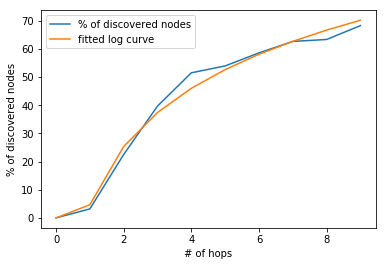

In [40]:
data = means / len(gc) * 100
plt.plot(data, label='% of discovered nodes')
x = np.arange(9)
a, b = np.polyfit(np.log(x+1), data[1:], 1)
print('log parameters:', a, b)
plt.plot(np.append([0], a*np.log(x+1) + b), label='fitted log curve')
plt.ylabel("% of discovered nodes")
plt.xlabel("# of hops")
plt.legend()

The average shortest path of 4.2 hops in such a big network is a strong indicator for a small world. Also, after 6 hops, we discovered 60% of the entire graph. <br>
Taking the definition of a small world from Wikipedia, the average shortest path in a graph should be proportional to the log of total discovered nodes. From the log curve that we fitted to the data, it is clearly visible that it follows this log curve and that this condition is satisfied.

#### Exercise 2.5: Network comparison

In [41]:
with open('../data/network2.csv') as file:
    data=[tuple(line) for line in csv.reader(filter(lambda row: row[0]!='#', file))]

G2 = nx.Graph(data)
print('Number of nodes:', G2.number_of_nodes())
print('Number of edges:', G2.number_of_edges())
degrees2 = np.fromiter(dict(G2.degree()).values(), dtype=int)
print('Average degree:', np.mean(degrees2))
print('Highest degree:', sorted(degrees2)[-1])

Number of nodes: 26542
Number of edges: 43516
Average degree: 3.2790294627383014
Highest degree: 8


In [42]:
def node_degree_distribution2(G, bins):
    degrees = np.fromiter(dict(G.degree()).values(), dtype=int)
    values = np.bincount(degrees)
    cumulative = G.number_of_nodes() - np.cumsum(values)

    figure(figsize=(15,4))
    plt.subplot(1,2,1)
    plt.title("Semilogy plot of node degrees")
    plt.xlabel("Degree")
    plt.ylabel("Number of nodes")
    plt.plot(values)
    
    plt.subplot(1,2,2)
    plt.plot(cumulative)

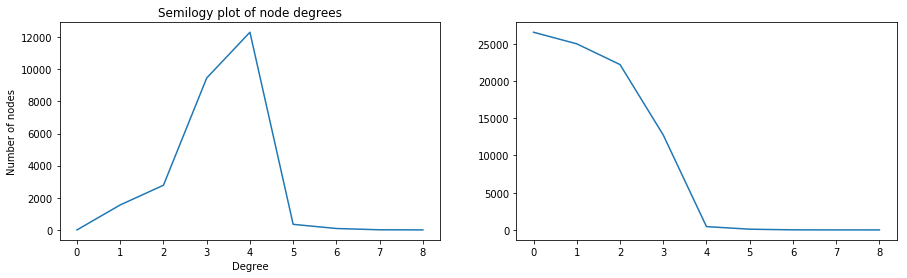

In [46]:
node_degree_distribution2(G2, 10)

This doesn't resemble to a pareto distribution. It is much more a gaussian distribution.

In [47]:
conn_components = sorted(nx.connected_components(G2), key = len, reverse=True)
print('# of connected components:', len(conn_components))
print('Size of largest component:', len(conn_components[0]), '; %f percent of total graph' % (len(conn_components[0])/G2.number_of_nodes()*100))
print('Size of second largest component:', len(conn_components[1]))

# of connected components: 5
Size of largest component: 26481 ; 99.770176 percent of total graph
Size of second largest component: 30


In [ ]:
avg2 = nx.average_shortest_path_length(G2.subgraph(conn_components[0]))

In [ ]:
print('Average shortest path length:', avg2)

In [ ]:
data = calc_means(list(conn_components[0])) / len(gc) *100
plt.plot(data, label='% of discovered nodes')
x = np.arange(9)
a, b = np.polyfit(np.log(x+1), data[1:], 1)
print('log parameters:', a, b)
plt.plot(np.append([0], a*np.log(x+1) + b), label='fitted log curve')
plt.ylabel("% of discovered nodes")
plt.xlabel("# of hops")
plt.legend()

#### Exercise 2.6: Network identification

Just by looking at the maximum and average node degree, we can quite confidently say that the first graph represents the subgraph of routers, while the second one represents the network of roads around New York, because it isn't possible for a roads-intersection to have 1482 incoming roads.<br>
Also, an average shortest path of 91 in a routers' network would be extremely inefficient. In fact, it is much easier to closely connect routers than intersections, because the connection is just a line and not an entire street. It can therefore be expected that the average shortest paths should be shorter than in a streets' network.